In [62]:
# Iain McIntosh
# 12/02/2023
# Python notebook to forecast future tracks based on trained model and input from multiple variables

# I think this is the first proof of concept for the multivariate model to predicted the path of the
# skateboarder based on real data from their body position

# ARIMA model achieved RMSE of approx 1,500 and from the plots was clearly correelating with the data
# ARIMA model appeared to have too large of a moving average window with large errors
# Random Forest model achieves RMSE of 111 untuned and the predictions on the graph look really good
# I believe the ML model is predicting the path of the wheel based on the values of the other feautures

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

print('Libraries imported')

Libraries imported


In [63]:
# Import filename to dataframe

filename = 'dftracks2000.csv'
dftracks = pd.read_csv(filename)
print(dftracks)

      Unnamed: 0  frame  point           X           Y
0              0      0      0  419.851607 -185.910416
1              1      0      1  422.501167 -231.862278
2              2      0      2  414.379417 -309.274549
3              3      0      3  444.198348 -307.433310
4              4      1      0  426.267678 -185.368552
...          ...    ...    ...         ...         ...
7995        7995   1998      3  609.988953 -271.791115
7996        7996   1999      0  553.572268 -179.189930
7997        7997   1999      1  555.061230 -214.345322
7998        7998   1999      2  572.671763 -290.351086
7999        7999   1999      3  605.283894 -275.897684

[8000 rows x 5 columns]


In [64]:
# format to match the format of the training data

# drop Unamed: 0 column
dftracks = dftracks.drop('Unnamed: 0', axis=1)

# remove X for simplicity - it is probably a great feature to use but it adds complexity
dftracks = dftracks.drop('X', axis=1)

# rename Y to target
dftracks.rename(columns={'Y':'target'}, inplace=True)

print(dftracks)

      frame  point      target
0         0      0 -185.910416
1         0      1 -231.862278
2         0      2 -309.274549
3         0      3 -307.433310
4         1      0 -185.368552
...     ...    ...         ...
7995   1998      3 -271.791115
7996   1999      0 -179.189930
7997   1999      1 -214.345322
7998   1999      2 -290.351086
7999   1999      3 -275.897684

[8000 rows x 3 columns]


In [65]:
# Transpose the dataframe to match the format required with features as columns and rows as time steps with target
df_transposed = dftracks.pivot(index='frame', columns='point', values='target')
# points are 0 = head, 1 = body, 2 = left wheel, 3 = right wheel

# name the columns correctly
df_transposed.columns = ['head', 'body', 'left_wheel', 'right_wheel']

# drop the right_wheel column as it is not needed for the model
df_transposed = df_transposed.drop('right_wheel', axis=1)

# rename head to feature 1, body to feature 2, left_wheel to target
df_transposed.rename(columns={'head':'feature1', 'body':'feature2', 'left_wheel':'target'}, inplace=True)

# rename frame to time
df_transposed.index.names = ['time']

print(df_transposed)

        feature1    feature2      target
time                                    
0    -185.910416 -231.862278 -309.274549
1    -185.368552 -232.258315 -308.638573
2    -185.618992 -232.514820 -308.138237
3    -186.854339 -232.880330 -308.353386
4    -187.769365 -233.168149 -307.565517
...          ...         ...         ...
1995 -172.106953 -207.930222 -278.053064
1996 -173.600478 -211.272225 -281.898823
1997 -175.300384 -211.103783 -284.530106
1998 -176.753268 -211.909933 -287.413130
1999 -179.189930 -214.345322 -290.351086

[2000 rows x 3 columns]


In [66]:
print(df_transposed.shape)
print(df_transposed.dtypes)

(2000, 3)
feature1    float64
feature2    float64
target      float64
dtype: object


In [67]:
# show the last 5 rows of the dataframe

print(df_transposed.tail())

        feature1    feature2      target
time                                    
1995 -172.106953 -207.930222 -278.053064
1996 -173.600478 -211.272225 -281.898823
1997 -175.300384 -211.103783 -284.530106
1998 -176.753268 -211.909933 -287.413130
1999 -179.189930 -214.345322 -290.351086


In [68]:
print(df_transposed.index)

timelist = pd.date_range('2023-01-01', periods=len(df_transposed), freq='50ms').tolist()

# set the idex to a datetime index
df_transposed.index = pd.to_datetime(timelist)

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999],
      dtype='int64', name='time', length=2000)


In [69]:
df = df_transposed

In [70]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]
print('Data split into training and testing sets')

Data split into training and testing sets


In [71]:
# Model
modeltype = 'RF'

if modeltype == 'ARIMA' :
    print('ARIMA model selected')
    # set model frequency to 50ms
    order = (1, 1, 1)  # Default order which will need to be tuned to best fit the data
    model = ARIMA(train['target'], exog=train[['feature1', 'feature2']], order=order, freq='50L')
    fit_model = model.fit()
    print('ARIMA model fitted\n')
    print(fit_model.summary())
    # Generate ARIMA forecast for test set
    forecast = fit_model.forecast(steps=len(test), exog=test[['feature1', 'feature2']])
    print('Forecast for test set completed')
elif modeltype == 'RF' :
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(train[['feature1', 'feature2']], train['target'])
    print('Random Forest model fitted')
    forecast = model.predict(test[['feature1', 'feature2']])
    print('Forecast for test set completed')


Random Forest model fitted
Forecast for test set completed


In [72]:
# Evaluate the model
mse = mean_squared_error(test['target'], forecast)
print(f'Model valuated with Mean Squared Error: {mse}')

# Save the model
fit_model.save('model.pkl')
print('Model saved')

Model valuated with Mean Squared Error: 110.54753889304196
Model saved


In [73]:
# print last 5 rows of df
print(df.tail())

                           feature1    feature2      target
2023-01-01 00:01:39.750 -172.106953 -207.930222 -278.053064
2023-01-01 00:01:39.800 -173.600478 -211.272225 -281.898823
2023-01-01 00:01:39.850 -175.300384 -211.103783 -284.530106
2023-01-01 00:01:39.900 -176.753268 -211.909933 -287.413130
2023-01-01 00:01:39.950 -179.189930 -214.345322 -290.351086


In [74]:
# create a new dataframe with the features required for the future predictions
# generate a list in time date format seperated by 0.05 seconds
# refactor this code to be automatic

timelist = pd.date_range('2023-01-01 00:01:40.000', periods=5, freq='50ms').tolist()

future = pd.DataFrame({'feature1': [-179.189930, -179.189930,-179.189930,-179.189930,-179.189930,], 'feature2': [-214.345322,-214.345322,-214.345322,-214.345322,-214.345322],
                        'futuretime': timelist})

# set the index of future dataframe to the futuretime column
future.set_index('futuretime', inplace=True)


# concatenate the future dataframe with the original dataframe
pred = pd.concat([df, future], ignore_index=False)

print('Dataframe for predicitons created')

Dataframe for predicitons created


In [75]:
# add a column to the dataframe with the forecast values
# check this is using the corect forecast value and model (random forest or ARIMA)
# ARIMA prediction
if modeltype == 'ARIMA' :
    prediction = fit_model.forecast(steps=len(pred), exog=pred[['feature1', 'feature2']])

# Random Forest prediction - errors
elif modeltype == 'RF' :
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(train[['feature1', 'feature2']], train['target'])
    print('Random Forest model fitted')
    print('Forecast for test set completed')
    prediction = pd.DataFrame(model.predict(pred[['feature1', 'feature2']]))
#prediction = model.predict(pred[['feature1', 'feature2']])

# sort the dataframe by the index
prediction.sort_index(inplace=True)

Random Forest model fitted
Forecast for test set completed


In [76]:
# add the forecast values to pred dataframe
pred['forecast'] = prediction.values

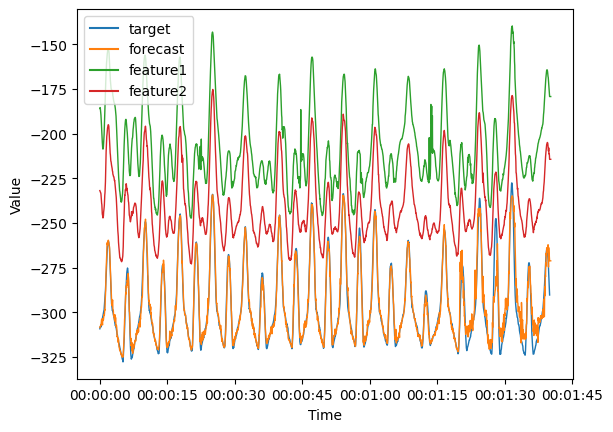


Data for chart above listed below

                           feature1    feature2      target    forecast
2023-01-01 00:00:00.000 -185.910416 -231.862278 -309.274549 -308.595464
2023-01-01 00:00:00.050 -185.368552 -232.258315 -308.638573 -308.183143
2023-01-01 00:00:00.100 -185.618992 -232.514820 -308.138237 -308.189394
2023-01-01 00:00:00.150 -186.854339 -232.880330 -308.353386 -307.739109
2023-01-01 00:00:00.200 -187.769365 -233.168149 -307.565517 -306.979780
...                             ...         ...         ...         ...
2023-01-01 00:01:40.000 -179.189930 -214.345322         NaN -271.203753
2023-01-01 00:01:40.050 -179.189930 -214.345322         NaN -271.203753
2023-01-01 00:01:40.100 -179.189930 -214.345322         NaN -271.203753
2023-01-01 00:01:40.150 -179.189930 -214.345322         NaN -271.203753
2023-01-01 00:01:40.200 -179.189930 -214.345322         NaN -271.203753

[2005 rows x 4 columns]


In [77]:
# plot the actual values vs the forecast values
plt.plot(pred['target'], label='target')
plt.plot(pred['forecast'], label='forecast')

# add feature1 and feature2 to the plot
plt.plot(pred['feature1'], label='feature1')
plt.plot(pred['feature2'], label='feature2')

plt.legend(loc='upper left')

# add labels to the plot
plt.xlabel('Time')
plt.ylabel('Value')

# set the plot lines to thickness 1
plt.setp(plt.gca().get_lines(), lw=1)

# show the plot
plt.show()

#print the dataframe
print('\nData for chart above listed below\n')
print(pred)